# 学習したSwAVのResNet50に全結合層付けて教師あり学習実行
- https://colab.research.google.com/github/ayulockin/SwAV-TF/blob/master/linear_evaluation/Linear_Evaluation_10_Epochs.ipynb#scrollTo=LROY2Mrn0wpY


In [1]:
# https://github.com/ayulockin/SwAV-TF/tree/master/utils
# architecture.py
from tensorflow.keras import layers
import tensorflow as tf

def get_resnet_backbone():
    base_model = tf.keras.applications.ResNet50(
        include_top=False, weights=None, input_shape=(None, None, 3)
    )
    base_model.trainabe = True

    inputs = layers.Input((None, None, 3))
    h = base_model(inputs, training=True)
    h = layers.GlobalAveragePooling2D()(h)
    backbone = tf.keras.models.Model(inputs, h)

    return backbone

In [2]:
@tf.function
def scale_resize_image(image_label):
    image, label = image_label["image"], image_label["label"]
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (224, 224)) # Resizing to highest resolution used while training swav
    return (image, label)

In [3]:
import tensorflow as tf
#import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import time
import os

from itertools import groupby
from tqdm import tqdm

tf.random.set_seed(666)
np.random.seed(666)

#tfds.disable_progress_bar()

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.3.1


In [4]:
# TPUの検出
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


# params

In [5]:
n_classes = 5  # キャッサバデータは5クラス

#feature_backbone_weights = "../input/swav-tf/feature_backbone.h5"
feature_backbone_weights = r"results\feature_backbone.h5"

#BATCH_SIZE = 64 * strategy.num_replicas_in_sync
BATCH_SIZE = 16

epochs = 100 #50
patience = 15

#DEBUG = True
DEBUG = False
if DEBUG:
    epochs = 2

# Cassava data
- https://www.kaggle.com/jessemostipak/getting-started-tpus-cassava-leaf-disease

In [6]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    return image

In [7]:
def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return {"image": image, "label": label}
    idnum = example['image_name']
    return {"image": image, "label": idnum}

In [8]:
from functools import partial

AUTO = tf.data.experimental.AUTOTUNE

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTO)
    return dataset

In [9]:
import re

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [10]:
#from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import train_test_split

## 自分のnotebookのoutputをtinputに入れてるからかエラーになる
#GCS_PATH = KaggleDatasets().get_gcs_path()
#train_tfrecs = tf.io.gfile.glob(GCS_PATH + '/train_tfrecords/ld_train*.tfrec')

#train_tfrecs = tf.io.gfile.glob('../input/cassava-leaf-disease-classification/train_tfrecords/ld_train*.tfrec')
train_tfrecs = tf.io.gfile.glob(r'C:\Users\81908\jupyter_notebook\pytorch_lightning_work\kaggle_Cassava\input\cassava-leaf-disease-classification\train_tfrecords\ld_train*.tfrec')

TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(train_tfrecs,
                                                       test_size=0.35, 
                                                       random_state=5)
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
print(f"NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES: {NUM_TRAINING_IMAGES}, {NUM_VALIDATION_IMAGES}")

NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES: 13380, 8017


In [11]:
train_ds = load_dataset(TRAINING_FILENAMES, labeled=True)
validation_ds = load_dataset(VALID_FILENAMES, labeled=True)

training_ds = (
    train_ds
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testing_ds = (
    validation_ds
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Linear Evaluation
## SwAVの重み固定して学習

In [12]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential, Model

lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5, 
    decay_steps=10000, 
    decay_rate=0.9)

def get_linear_classifier():        
    # input placeholder
    inputs = Input(shape=(224, 224, 3))

    # get swav baseline model architecture
    feature_backbone = get_resnet_backbone()

    # load trained weights
    feature_backbone.load_weights(feature_backbone_weights)
    feature_backbone.trainable = False
    x = feature_backbone(inputs, training=False)

    outputs = Dense(n_classes, activation="softmax")(x)
    linear_model = Model(inputs, outputs)
    
    linear_model.compile(loss="sparse_categorical_crossentropy", 
                         metrics=["acc"],
                         optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler, epsilon=0.001),
                        )

    return linear_model

## Without Augmentation

In [13]:
%%time
# get model and compile
tf.keras.backend.clear_session()

model = get_linear_classifier()
model.summary()
for l in model.layers:
    print(l.name, l.trainable)
print()

early_stopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                 patience=patience, 
                                                 verbose=2, 
                                                 restore_best_weights=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="swav_without_augment.h5", 
                                                monitor='val_loss', 
                                                save_best_only=True)

# train 
history = model.fit(training_ds,
                    validation_data=(testing_ds),
                    epochs=epochs,
                    callbacks=[early_stopper, checkpoint],
                    steps_per_epoch=NUM_TRAINING_IMAGES // BATCH_SIZE, 
                    validation_steps=NUM_VALIDATION_IMAGES // BATCH_SIZE, 
                   )

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
functional_1 (Functional)    (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________
input_1 True
functional_1 False
dense True

Epoch 1/100
836/836 [==============================] - 49s 59ms/step - loss: 1.3096 - acc: 0.6060 - val_loss: 1.2179 - val_acc: 0.6077
Epoch 2/100
836/836 [==============================] - 48s 58ms/step - loss: 1.1860 - acc: 0.6189 - val_loss: 1.1933 - val_acc: 0.6084
Epoch 3/100
836/836 [==============================] 

836/836 [==============================] - 49s 59ms/step - loss: 1.1421 - acc: 0.6236 - val_loss: 1.1634 - val_acc: 0.6110
Epoch 56/100
836/836 [==============================] - 49s 59ms/step - loss: 1.1441 - acc: 0.6227 - val_loss: 1.1642 - val_acc: 0.6115
Epoch 57/100
836/836 [==============================] - 50s 60ms/step - loss: 1.1414 - acc: 0.6243 - val_loss: 1.1626 - val_acc: 0.6110
Epoch 58/100
836/836 [==============================] - 48s 57ms/step - loss: 1.1415 - acc: 0.6241 - val_loss: 1.1631 - val_acc: 0.6114
Epoch 59/100
836/836 [==============================] - 48s 57ms/step - loss: 1.1401 - acc: 0.6237 - val_loss: 1.1630 - val_acc: 0.6123
Epoch 60/100
836/836 [==============================] - 49s 59ms/step - loss: 1.1401 - acc: 0.6242 - val_loss: 1.1624 - val_acc: 0.6125
Epoch 61/100
836/836 [==============================] - 49s 59ms/step - loss: 1.1396 - acc: 0.6247 - val_loss: 1.1619 - val_acc: 0.6113
Epoch 62/100
836/836 [==============================] - 50s 6

<AxesSubplot:>

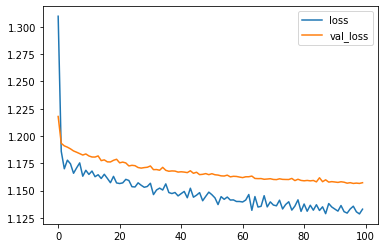

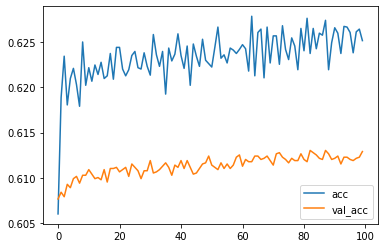

In [14]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['acc', 'val_acc']].plot()

In [15]:
loss, acc = model.evaluate(testing_ds)

502/502 [==============================] - 18s 35ms/step - loss: 1.1572 - acc: 0.6129


## With Augmentation

In [13]:
# Configs
CROP_SIZE = 224
MIN_SCALE = 0.5
MAX_SCALE = 1.

# Experimental options
options = tf.data.Options()
options.experimental_optimization.noop_elimination = True
options.experimental_optimization.map_vectorization.enabled = True
options.experimental_optimization.apply_default_optimizations = True
options.experimental_deterministic = False
options.experimental_threading.max_intra_op_parallelism = 1

In [14]:
@tf.function
def scale_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    return (image, label)

@tf.function
def random_apply(func, x, p):
    return tf.cond(
        tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                tf.cast(p, tf.float32)),
        lambda: func(x),
        lambda: x)
 
@tf.function
def random_resize_crop(image, label):
    # Conditional resizing
    image = tf.image.resize(image, (260, 260))
    # Get the crop size for given min and max scale
    size = tf.random.uniform(shape=(1,), minval=MIN_SCALE*260,
                             maxval=MAX_SCALE*260, dtype=tf.float32)
    size = tf.cast(size, tf.int32)[0]
    # Get the crop from the image
    crop = tf.image.random_crop(image, (size,size,3))
    crop_resize = tf.image.resize(crop, (CROP_SIZE, CROP_SIZE))
    
    return crop_resize, label

@tf.function
def tie_together(image_label):
    image, label = image_label["image"], image_label["label"]
    # Scale the pixel values
    image, label = scale_image(image , label)
    # random horizontal flip
    image = random_apply(tf.image.random_flip_left_right, image, p=0.5)
    # Random resized crops
    image, label = random_resize_crop(image, label)

    return image, label

In [15]:
training_ds = (
    train_ds
    .map(tie_together, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

training_ds = training_ds.with_options(options)

In [19]:
%%time
# get model and compile
tf.keras.backend.clear_session()
model = get_linear_classifier()
model.summary()
for l in model.layers:
    print(l.name, l.trainable)
print()

early_stopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                 patience=patience, 
                                                 verbose=2, 
                                                 restore_best_weights=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="swav_augment.h5", 
                                                monitor='val_loss', 
                                                save_best_only=True)

# train 
history = model.fit(training_ds,
                    validation_data=(testing_ds),
                    epochs=epochs,
                    callbacks=[early_stopper, checkpoint],
                    steps_per_epoch=NUM_TRAINING_IMAGES // BATCH_SIZE, 
                    validation_steps=NUM_VALIDATION_IMAGES // BATCH_SIZE,
                   )

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
functional_1 (Functional)    (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________
input_1 True
functional_1 False
dense True

Epoch 1/100
836/836 [==============================] - 48s 58ms/step - loss: 1.3328 - acc: 0.5716 - val_loss: 1.1978 - val_acc: 0.6072
Epoch 2/100
836/836 [==============================] - 48s 57ms/step - loss: 1.1823 - acc: 0.6160 - val_loss: 1.1884 - val_acc: 0.6070
Epoch 3/100
836/836 [==============================] 

836/836 [==============================] - 48s 57ms/step - loss: 1.1516 - acc: 0.6231 - val_loss: 1.1653 - val_acc: 0.6115
Epoch 56/100
836/836 [==============================] - 48s 58ms/step - loss: 1.1558 - acc: 0.6208 - val_loss: 1.1653 - val_acc: 0.6114
Epoch 57/100
836/836 [==============================] - 49s 59ms/step - loss: 1.1509 - acc: 0.6231 - val_loss: 1.1641 - val_acc: 0.6110
Epoch 58/100
836/836 [==============================] - 47s 56ms/step - loss: 1.1475 - acc: 0.6249 - val_loss: 1.1671 - val_acc: 0.6115
Epoch 59/100
836/836 [==============================] - 48s 57ms/step - loss: 1.1590 - acc: 0.6185 - val_loss: 1.1636 - val_acc: 0.6108
Epoch 60/100
836/836 [==============================] - 48s 57ms/step - loss: 1.1525 - acc: 0.6221 - val_loss: 1.1637 - val_acc: 0.6117
Epoch 61/100
836/836 [==============================] - 48s 57ms/step - loss: 1.1449 - acc: 0.6266 - val_loss: 1.1641 - val_acc: 0.6124
Epoch 62/100
836/836 [==============================] - 47s 5

<AxesSubplot:>

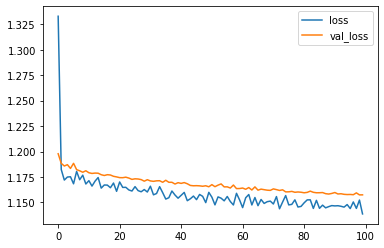

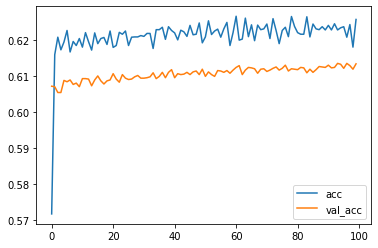

In [20]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['acc', 'val_acc']].plot()

In [21]:
loss, acc = model.evaluate(testing_ds)

502/502 [==============================] - 17s 33ms/step - loss: 1.1574 - acc: 0.6134


# 10％のラベル付きデータだけでFine Tuning
- ラベル付きデータが非常に少ないケース
- 最初にSwAVの重みを凍結してトレーニング（通常、高い学習率で実行）
- 次に、全層をより低い学習率でトレーニング
- https://colab.research.google.com/github/ayulockin/SwAV-TF/blob/master/fine_tuning/Fine_Tuning_10_Epochs.ipynb

In [22]:
TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(train_tfrecs,
                                                       test_size=0.35, 
                                                       random_state=5)

TRAINING_FILENAMES, extra_TRAINING_FILENAMES = train_test_split(TRAINING_FILENAMES,
                                                                test_size=0.9, 
                                                                random_state=5)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_extra_TRAINING_IMAGES = count_data_items(extra_TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
print(f"NUM_TRAINING_IMAGES, NUM_extra_TRAINING_IMAGES, NUM_VALIDATION_IMAGES: {NUM_TRAINING_IMAGES}, {NUM_extra_TRAINING_IMAGES}, {NUM_VALIDATION_IMAGES}")

train_ds = load_dataset(TRAINING_FILENAMES, labeled=True)
extra_train_ds = load_dataset(extra_TRAINING_FILENAMES, labeled=True)
validation_ds = load_dataset(VALID_FILENAMES, labeled=True)

# 10％のラベル付きデータ
training_ds = (
    train_ds
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(256)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testing_ds = (
    validation_ds
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

NUM_TRAINING_IMAGES, NUM_extra_TRAINING_IMAGES, NUM_VALIDATION_IMAGES: 1338, 12042, 8017


## With Augmentation

In [23]:
# 10％のラベル付きデータ
training_ds = (
    train_ds
    .map(tie_together, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(256)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

training_ds = training_ds.with_options(options)

## 1.SwAVの重み固定して学習

In [24]:
%%time
# get model and compile
tf.keras.backend.clear_session()
model = get_linear_classifier()
model.summary()
for l in model.layers:
    print(l.name, l.trainable)
print()

early_stopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                 patience=patience, 
                                                 verbose=2, 
                                                 restore_best_weights=True)

# train
history = model.fit(training_ds,
                    validation_data=(testing_ds),
                    epochs=epochs,
                    callbacks=[early_stopper],
                    steps_per_epoch=NUM_TRAINING_IMAGES // BATCH_SIZE, 
                    validation_steps=NUM_VALIDATION_IMAGES // BATCH_SIZE,
                   )

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
functional_1 (Functional)    (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________
input_1 True
functional_1 False
dense True

Epoch 1/100
83/83 [==============================] - 20s 245ms/step - loss: 2.3738 - acc: 0.0663 - val_loss: 1.6963 - val_acc: 0.1972
Epoch 2/100
83/83 [==============================] - 20s 238ms/step - loss: 1.5005 - acc: 0.5452 - val_loss: 1.3597 - val_acc: 0.6075
Epoch 3/100
83/83 [==============================] - 20

Epoch 56/100
83/83 [==============================] - 20s 237ms/step - loss: 1.1755 - acc: 0.6190 - val_loss: 1.1866 - val_acc: 0.6099
Epoch 57/100
83/83 [==============================] - 20s 238ms/step - loss: 1.1858 - acc: 0.6084 - val_loss: 1.1857 - val_acc: 0.6092
Epoch 58/100
83/83 [==============================] - 20s 237ms/step - loss: 1.1881 - acc: 0.6160 - val_loss: 1.1885 - val_acc: 0.6099
Epoch 59/100
83/83 [==============================] - 20s 237ms/step - loss: 1.1966 - acc: 0.6054 - val_loss: 1.1861 - val_acc: 0.6090
Epoch 60/100
83/83 [==============================] - 20s 237ms/step - loss: 1.1796 - acc: 0.6160 - val_loss: 1.1858 - val_acc: 0.6099
Epoch 61/100
83/83 [==============================] - 20s 239ms/step - loss: 1.1909 - acc: 0.6122 - val_loss: 1.1868 - val_acc: 0.6092
Epoch 62/100
83/83 [==============================] - 20s 238ms/step - loss: 1.1980 - acc: 0.6107 - val_loss: 1.1852 - val_acc: 0.6088
Epoch 63/100
83/83 [==============================] - 2

In [25]:
model.save('warmup.h5')

## 2.Fine tune CNN（1.の重みロードして全層学習）

In [30]:
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-6,  # 学習率下げてる
    decay_steps=10000, 
    decay_rate=0.9)
    
    
def get_classifier():
    # load warmup model
    warmup_model = tf.keras.models.load_model('warmup.h5')
    warmup_model.trainable = True
    
    warmup_model.compile(loss="sparse_categorical_crossentropy", 
                         metrics=["acc"],
                         optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler, epsilon=0.001),
                        )

    return warmup_model

In [31]:
%%time
# get model and compile
tf.keras.backend.clear_session()
full_trainable_model = get_classifier()
full_trainable_model.summary()
for l in full_trainable_model.layers:
    print(l.name, l.trainable)
print()
    
early_stopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                 patience=patience, 
                                                 verbose=2, 
                                                 restore_best_weights=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="swav_finetuning.h5", 
                                                monitor='val_loss', 
                                                save_best_only=True)

# train                                              
history = full_trainable_model.fit(training_ds,
                                   validation_data=(testing_ds),
                                   epochs=epochs*3,
                                   callbacks=[early_stopper, checkpoint],
                                   steps_per_epoch=NUM_TRAINING_IMAGES // BATCH_SIZE, 
                                   validation_steps=NUM_VALIDATION_IMAGES // BATCH_SIZE,
                                  )

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
functional_1 (Functional)    (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 23,544,837
Non-trainable params: 53,120
_________________________________________________________________
input_1 True
functional_1 True
dense True

Epoch 1/300
83/83 [==============================] - 31s 375ms/step - loss: 1.1969 - acc: 0.6092 - val_loss: 1.1941 - val_acc: 0.6079
Epoch 2/300
83/83 [==============================] - 31s 369ms/step - loss: 1.2039 - acc: 0.6092 - val_loss: 1.1924 - val_acc: 0.6079
Epoch 3/300
83/83 [==============================] - 31s

Epoch 56/300
83/83 [==============================] - 28s 340ms/step - loss: 1.1355 - acc: 0.6175 - val_loss: 1.1476 - val_acc: 0.6114
Epoch 57/300
83/83 [==============================] - 30s 356ms/step - loss: 1.1391 - acc: 0.6227 - val_loss: 1.1451 - val_acc: 0.6115
Epoch 58/300
83/83 [==============================] - 29s 349ms/step - loss: 1.1456 - acc: 0.6092 - val_loss: 1.1468 - val_acc: 0.6115
Epoch 59/300
83/83 [==============================] - 30s 357ms/step - loss: 1.1392 - acc: 0.6167 - val_loss: 1.1434 - val_acc: 0.6123
Epoch 60/300
83/83 [==============================] - 28s 340ms/step - loss: 1.1338 - acc: 0.6182 - val_loss: 1.1448 - val_acc: 0.6119
Epoch 61/300
83/83 [==============================] - 29s 344ms/step - loss: 1.1346 - acc: 0.6137 - val_loss: 1.1438 - val_acc: 0.6114
Epoch 62/300
83/83 [==============================] - 29s 355ms/step - loss: 1.1290 - acc: 0.6197 - val_loss: 1.1431 - val_acc: 0.6124
Epoch 63/300
83/83 [==============================] - 2

83/83 [==============================] - 29s 348ms/step - loss: 1.0925 - acc: 0.6295 - val_loss: 1.1164 - val_acc: 0.6159
Epoch 117/300
83/83 [==============================] - 29s 352ms/step - loss: 1.1164 - acc: 0.6190 - val_loss: 1.1181 - val_acc: 0.6186
Epoch 118/300
83/83 [==============================] - 28s 341ms/step - loss: 1.0808 - acc: 0.6318 - val_loss: 1.1166 - val_acc: 0.6171
Epoch 119/300
83/83 [==============================] - 28s 340ms/step - loss: 1.0977 - acc: 0.6152 - val_loss: 1.1149 - val_acc: 0.6156
Epoch 120/300
83/83 [==============================] - 28s 336ms/step - loss: 1.1115 - acc: 0.6160 - val_loss: 1.1169 - val_acc: 0.6165
Epoch 121/300
83/83 [==============================] - 28s 338ms/step - loss: 1.0830 - acc: 0.6310 - val_loss: 1.1112 - val_acc: 0.6178
Epoch 122/300
83/83 [==============================] - 28s 336ms/step - loss: 1.1265 - acc: 0.6137 - val_loss: 1.1161 - val_acc: 0.6168
Epoch 123/300
83/83 [==============================] - 28s 338

83/83 [==============================] - 30s 364ms/step - loss: 1.0877 - acc: 0.6280 - val_loss: 1.0953 - val_acc: 0.6229
Epoch 177/300
83/83 [==============================] - 30s 362ms/step - loss: 1.0741 - acc: 0.6333 - val_loss: 1.0962 - val_acc: 0.6213
Epoch 178/300
83/83 [==============================] - 30s 362ms/step - loss: 1.0721 - acc: 0.6250 - val_loss: 1.0950 - val_acc: 0.6200
Epoch 179/300
83/83 [==============================] - 30s 360ms/step - loss: 1.0459 - acc: 0.6416 - val_loss: 1.0942 - val_acc: 0.6224
Epoch 180/300
83/83 [==============================] - 30s 365ms/step - loss: 1.0819 - acc: 0.6295 - val_loss: 1.0965 - val_acc: 0.6208
Epoch 181/300
83/83 [==============================] - 30s 362ms/step - loss: 1.0647 - acc: 0.6258 - val_loss: 1.0978 - val_acc: 0.6211
Epoch 182/300
83/83 [==============================] - 31s 373ms/step - loss: 1.0698 - acc: 0.6295 - val_loss: 1.0930 - val_acc: 0.6230
Epoch 183/300
83/83 [==============================] - 31s 371

83/83 [==============================] - 32s 384ms/step - loss: 1.0745 - acc: 0.6295 - val_loss: 1.0857 - val_acc: 0.6219
Epoch 237/300
83/83 [==============================] - 32s 381ms/step - loss: 1.0366 - acc: 0.6423 - val_loss: 1.0829 - val_acc: 0.6220
Epoch 238/300
83/83 [==============================] - 32s 386ms/step - loss: 1.0444 - acc: 0.6325 - val_loss: 1.0870 - val_acc: 0.6216
Epoch 239/300
83/83 [==============================] - 32s 380ms/step - loss: 1.0612 - acc: 0.6370 - val_loss: 1.0833 - val_acc: 0.6220
Epoch 240/300
83/83 [==============================] - 30s 362ms/step - loss: 1.0710 - acc: 0.6265 - val_loss: 1.0826 - val_acc: 0.6239
Epoch 241/300
83/83 [==============================] - 30s 366ms/step - loss: 1.0391 - acc: 0.6491 - val_loss: 1.0803 - val_acc: 0.6238
Epoch 242/300
83/83 [==============================] - 30s 362ms/step - loss: 1.0432 - acc: 0.6348 - val_loss: 1.0828 - val_acc: 0.6241
Epoch 243/300
83/83 [==============================] - 30s 358

<AxesSubplot:>

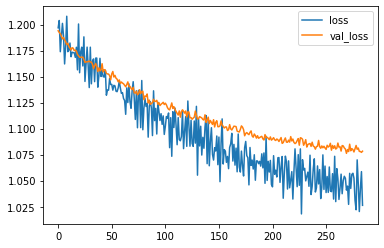

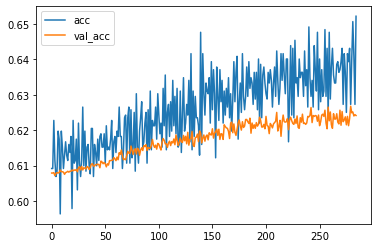

In [32]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['acc', 'val_acc']].plot()

In [33]:
loss, acc = full_trainable_model.evaluate(testing_ds)

502/502 [==============================] - 19s 38ms/step - loss: 1.0803 - acc: 0.6245


# 1%のラベル付きデータだけでFine Tuning

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold

df = pd.read_csv(r'C:\Users\81908\jupyter_notebook\pytorch_lightning_work\kaggle_Cassava\input\cassava-leaf-disease-classification\train.csv')

n_splits = 100

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
for fold, (trn_idx, val_idx) in enumerate(skf.split(np.arange(df.shape[0]), df.label.values)):
    df.loc[df.iloc[val_idx].index, 'fold'] = fold

#df["filepath"] = f"../input/cassava-leaf-disease-classification/train_images/" + df["image_id"]
_dir = "C:\\Users\\81908\\jupyter_notebook\\pytorch_lightning_work\\kaggle_Cassava\\input\\cassava-leaf-disease-classification\\train_images\\"
df["filepath"] =  _dir + df["image_id"] #[os.path.join(_dir, p) for p in df["image_id"]]
display(df.head())

train_df = df[df["fold"] == 0]
print('train_df Class distribution per fold.\n', train_df['label'].value_counts())

print()

val35per = list(range(65,100))
validation_df = df[df["fold"].isin(val35per)]
print('validation_df Class distribution per fold.\n', validation_df['label'].value_counts())

TRAINING_FILENAMES = train_df["filepath"]
VALID_FILENAMES = validation_df["filepath"]
NUM_TRAINING_IMAGES = len(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = len(VALID_FILENAMES)

print(df["filepath"][0])

,image_id,label,fold,filepath
0,1000015157.jpg,0,67.0,C:\Users\81908\jupyter_notebook\pytorch_lightn...
1,1000201771.jpg,3,55.0,C:\Users\81908\jupyter_notebook\pytorch_lightn...
2,100042118.jpg,1,48.0,C:\Users\81908\jupyter_notebook\pytorch_lightn...
3,1000723321.jpg,1,34.0,C:\Users\81908\jupyter_notebook\pytorch_lightn...
4,1000812911.jpg,3,57.0,C:\Users\81908\jupyter_notebook\pytorch_lightn...


train_df Class distribution per fold.
 3    132
4     25
2     24
1     22
0     11
Name: label, dtype: int64

validation_df Class distribution per fold.
 3    4598
4     907
2     840
1     770
0     372
Name: label, dtype: int64
C:\Users\81908\jupyter_notebook\pytorch_lightning_work\kaggle_Cassava\input\cassava-leaf-disease-classification\train_images\1000015157.jpg


In [17]:
@tf.function
def load_image_and_label_from_path(image_path, label):
    img = tf.io.read_file(image_path)  # 画像パスロード
    img = tf.image.decode_jpeg(img, channels=3)  # jpegファイルロード
    img = tf.cast(img, tf.float32) / 255.0  # 正規化
    img = tf.image.resize(img, (224, 224)) # Resizing
    return img, tf.cast(label, tf.int32)  # ラベルもtf型に変換

@tf.function
def load_image_and_label_from_path_augment(image_path, label):
    img = tf.io.read_file(image_path)  # 画像パスロード
    img = tf.image.decode_jpeg(img, channels=3)  # jpegファイルロード
    img = tf.cast(img, tf.float32) / 255.0  # 正規化
    img, label = scale_image(img, label)
    img = random_apply(tf.image.random_flip_left_right, img, p=0.5)
    img, label = random_resize_crop(img, label)
    return img, tf.cast(label, tf.int32)  # ラベルもtf型に変換

# Seriesからtf.data.Datasetに変換
training_data = tf.data.Dataset.from_tensor_slices((train_df.filepath.values, train_df.label.values))
validation_data = tf.data.Dataset.from_tensor_slices((validation_df.filepath.values, validation_df.label.values))

AUTO = tf.data.experimental.AUTOTUNE

training_ds = (
    training_data
    .map(load_image_and_label_from_path_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(buffer_size=32)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTO)
)
training_ds.with_options(options)

testing_ds = (
    validation_data
    .map(load_image_and_label_from_path, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTO)
)

## 1.SwAVの重み固定して学習

In [18]:
%%time
# get model and compile
tf.keras.backend.clear_session()
model = get_linear_classifier()
model.summary()
for l in model.layers:
    print(l.name, l.trainable)
print()

early_stopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                 patience=patience, 
                                                 verbose=2, 
                                                 restore_best_weights=True)

# train
history = model.fit(training_ds,
                    validation_data=(testing_ds),
                    epochs=epochs,
                    callbacks=[early_stopper],
                    steps_per_epoch=NUM_TRAINING_IMAGES // BATCH_SIZE, 
                    validation_steps=NUM_VALIDATION_IMAGES // BATCH_SIZE,
                   )

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
functional_1 (Functional)    (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________
input_1 True
functional_1 False
dense True

Epoch 1/100
13/13 [==============================] - 20s 2s/step - loss: 2.2776 - acc: 0.1106 - val_loss: 2.0511 - val_acc: 0.1209
Epoch 2/100
13/13 [==============================] - 19s 1s/step - loss: 1.9810 - acc: 0.1298 - val_loss: 1.8361 - val_acc: 0.1221
Epoch 3/100
13/13 [==============================] - 19s 1s/s

13/13 [==============================] - 19s 1s/step - loss: 1.1673 - acc: 0.6106 - val_loss: 1.1952 - val_acc: 0.6140
Epoch 58/100
13/13 [==============================] - 19s 1s/step - loss: 1.2123 - acc: 0.6058 - val_loss: 1.1945 - val_acc: 0.6144
Epoch 59/100
13/13 [==============================] - 19s 1s/step - loss: 1.1703 - acc: 0.6346 - val_loss: 1.1939 - val_acc: 0.6144
Epoch 60/100
13/13 [==============================] - 19s 1s/step - loss: 1.1209 - acc: 0.6346 - val_loss: 1.1941 - val_acc: 0.6146
Epoch 61/100
13/13 [==============================] - 19s 1s/step - loss: 1.1567 - acc: 0.6154 - val_loss: 1.1939 - val_acc: 0.6146
Epoch 62/100
13/13 [==============================] - 19s 1s/step - loss: 1.2061 - acc: 0.6058 - val_loss: 1.1931 - val_acc: 0.6147
Epoch 63/100
13/13 [==============================] - 19s 1s/step - loss: 1.1608 - acc: 0.6106 - val_loss: 1.1921 - val_acc: 0.6150
Epoch 64/100
13/13 [==============================] - 19s 1s/step - loss: 1.1548 - acc: 0

In [19]:
model.save('warmup_1per.h5')

## 2.Fine tune CNN（1.の重みロードして全層学習）

In [20]:
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-6,  # 学習率下げてる
    decay_steps=10000, 
    decay_rate=0.9)
    
    
def get_classifier():
    # load warmup model
    warmup_model = tf.keras.models.load_model('warmup_1per.h5')
    warmup_model.trainable = True
    
    warmup_model.compile(loss="sparse_categorical_crossentropy", 
                         metrics=["acc"],
                         optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler, epsilon=0.001),
                        )

    return warmup_model

In [21]:
%%time
# get model and compile
tf.keras.backend.clear_session()
full_trainable_model = get_classifier()
full_trainable_model.summary()
for l in full_trainable_model.layers:
    print(l.name, l.trainable)
print()
    
early_stopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                 patience=patience, 
                                                 verbose=2, 
                                                 restore_best_weights=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="swav_finetuning_1per.h5", 
                                                monitor='val_loss', 
                                                save_best_only=True)

# train                                              
history = full_trainable_model.fit(training_ds,
                                   validation_data=(testing_ds),
                                   epochs=epochs*3,
                                   callbacks=[early_stopper, checkpoint],
                                   steps_per_epoch=NUM_TRAINING_IMAGES // BATCH_SIZE, 
                                   validation_steps=NUM_VALIDATION_IMAGES // BATCH_SIZE,
                                  )

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
functional_1 (Functional)    (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 23,544,837
Non-trainable params: 53,120
_________________________________________________________________
input_1 True
functional_1 True
dense True

Epoch 1/300
13/13 [==============================] - 26s 2s/step - loss: 1.1245 - acc: 0.6346 - val_loss: 1.1922 - val_acc: 0.6140
Epoch 2/300
13/13 [==============================] - 25s 2s/step - loss: 1.2019 - acc: 0.5962 - val_loss: 1.1882 - val_acc: 0.6136
Epoch 3/300
13/13 [==============================] - 24s 2s/st

13/13 [==============================] - 24s 2s/step - loss: 1.1269 - acc: 0.6010 - val_loss: 1.1709 - val_acc: 0.6095
Epoch 58/300
13/13 [==============================] - 25s 2s/step - loss: 1.1396 - acc: 0.6154 - val_loss: 1.1705 - val_acc: 0.6115
Epoch 59/300
13/13 [==============================] - 24s 2s/step - loss: 1.1503 - acc: 0.6106 - val_loss: 1.1707 - val_acc: 0.6112
Epoch 60/300
13/13 [==============================] - 24s 2s/step - loss: 1.1431 - acc: 0.6154 - val_loss: 1.1713 - val_acc: 0.6128
Epoch 61/300
13/13 [==============================] - 24s 2s/step - loss: 1.1300 - acc: 0.6106 - val_loss: 1.1712 - val_acc: 0.6127
Epoch 62/300
13/13 [==============================] - 24s 2s/step - loss: 1.1187 - acc: 0.6202 - val_loss: 1.1710 - val_acc: 0.6119
Epoch 63/300
13/13 [==============================] - 24s 2s/step - loss: 1.1578 - acc: 0.6106 - val_loss: 1.1710 - val_acc: 0.6116
Epoch 64/300
13/13 [==============================] - 24s 2s/step - loss: 1.0933 - acc: 0

13/13 [==============================] - 24s 2s/step - loss: 1.1105 - acc: 0.6154 - val_loss: 1.1671 - val_acc: 0.6081
Epoch 120/300
13/13 [==============================] - 24s 2s/step - loss: 1.1148 - acc: 0.6394 - val_loss: 1.1667 - val_acc: 0.6085
Epoch 121/300
13/13 [==============================] - 24s 2s/step - loss: 1.1060 - acc: 0.6394 - val_loss: 1.1672 - val_acc: 0.6088
Epoch 122/300
13/13 [==============================] - 24s 2s/step - loss: 1.0970 - acc: 0.6298 - val_loss: 1.1667 - val_acc: 0.6089
Epoch 123/300
13/13 [==============================] - 24s 2s/step - loss: 1.1656 - acc: 0.6106 - val_loss: 1.1663 - val_acc: 0.6091
Epoch 124/300
13/13 [==============================] - 24s 2s/step - loss: 1.0793 - acc: 0.6394 - val_loss: 1.1656 - val_acc: 0.6089
Epoch 125/300
13/13 [==============================] - 24s 2s/step - loss: 1.1178 - acc: 0.6058 - val_loss: 1.1655 - val_acc: 0.6080
Epoch 126/300
13/13 [==============================] - 24s 2s/step - loss: 1.0935 -

<AxesSubplot:>

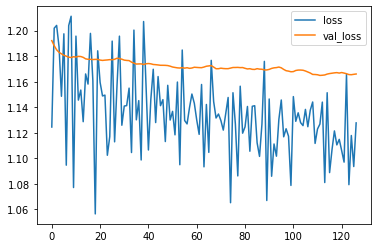

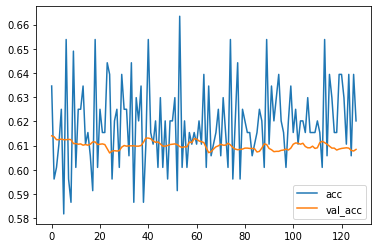

In [22]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['acc', 'val_acc']].plot()

In [23]:
loss, acc = full_trainable_model.evaluate(testing_ds)

468/468 [==============================] - 23s 49ms/step - loss: 1.1646 - acc: 0.6112
